In [4]:
import os
import sys
import pickle
import random
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.preprocessing import minmax_scale, scale, StandardScaler

sys.path.append(f"{os.getcwd()}/../")

from src.data.processing.utils import CleanUp, SNOWBALL_STEMMER
from src.database.models import RawHashtagComments, UserLocation

sns.set(style="darkgrid")
%matplotlib inline

normalizar = CleanUp(remove_stopwords=True)

In [5]:
df_covid = pd.read_csv("https://raw.githubusercontent.com/rdenadai/covid19statistics/master/data/covid-19/brazil/cases-brazil-cities-time-2020-06-08.csv")
print(df_covid.columns)

Index(['date', 'country', 'state', 'city', 'ibgeID', 'newDeaths', 'deaths',
       'newCases', 'totalCases', 'deaths_per_100k_inhabitants',
       'totalCases_per_100k_inhabitants', 'deaths_by_totalCases', '_source'],
      dtype='object')


In [6]:
hashtags_ = pd.DataFrame(list(RawHashtagComments.select().dicts()))
hashtags_ = hashtags_.drop(["hash"], axis=1)
users_ = pd.DataFrame(list(UserLocation.select().dicts()))

In [7]:
print(hashtags_.columns)
print(users_.columns)

Index(['hashtag', 'username', 'comment', 'data', 'timestamp', 'clean_comment',
       'sanitized_comment', 'classify'],
      dtype='object')
Index(['id', 'username', 'city', 'state', 'region', 'geo'], dtype='object')


In [8]:
print(f"Qtde. de Comentarios            : {len(hashtags_)}")
print(f"Qtde. de Comentarios positivos  : {len(hashtags_[hashtags_['classify'] == 'positivo'])}")
print(f"Qtde. de Comentarios negativos  : {len(hashtags_[hashtags_['classify'] == 'negativo'])}")
print("-" * 40)
print(f"Qtde. de Usuarios geolocalizados: {len(users_)}")
print(f"Qtde. de Usuarios em SP         : {len(users_[users_['state'] == 'SP'])}")
print(f"Qtde. de Usuarios em RJ         : {len(users_[users_['state'] == 'RJ'])}")

Qtde. de Comentarios            : 205870
Qtde. de Comentarios positivos  : 97400
Qtde. de Comentarios negativos  : 108441
----------------------------------------
Qtde. de Usuarios geolocalizados: 49144
Qtde. de Usuarios em SP         : 9672
Qtde. de Usuarios em RJ         : 10267


Exemplos de comentarios com suas classificacoes:

In [9]:
for idx, row in hashtags_.sample(n=5).iterrows():
    print(f"{row.classify}|{row.comment}")

negativo|Nossa querida  @fabianesecches  esta no Uol falando sobre a Febre Ferrante e seu livro, "Elena Ferrante: Uma longa experiência de ausência". Vem! Livro discute os best-sellers da 'Febre Ferrante' pelo olhar da psicanálise A psicanalista Fabiane Secches estava folheando um livro qualquer, em uma livraria, quando... tab.uol.com.br
negativo|Em resposta a  @itskurdt n sejamos radical, n seja radical ! frio so da dor de garganta e resfriado, e quando você vai toma banho     PIOR AINDA, morro
positivo|Tô com dor de cabeça, febre e tô ficando resfriado tnc
negativo|Cada dia uma coisa ruim acontece não basta essa merda do corona vírus agora o preconceito resolveu atacar aff , cada vez o mundo me decepciona mais quando mais eu tenho esperança mais elas ficam para trás #VidasPretasImportam Estou com vcs vidas pretas importam
positivo|Queria ter ido pra BC com as meninas mas fiquei com medo por conta do corona :/ só que eu estou trabalhando todos os dias já vsfd


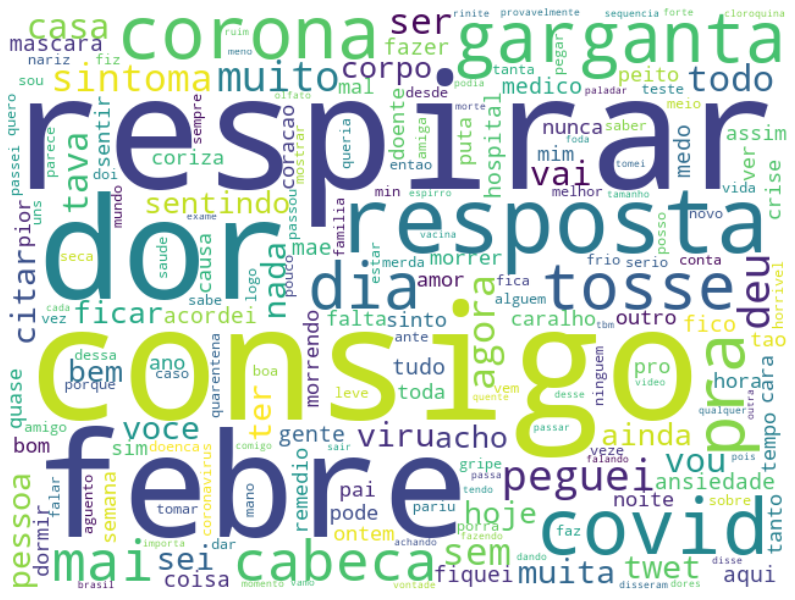

In [23]:
wordcloud = WordCloud(
    width=640, height=480,
    background_color="white", collocations=False,
    stopwords=["nao", "estou", "duvida"]
).generate(" ".join([normalizar.fit(frase) for frase in hashtags_["clean_comment"].tolist()]))

plt.figure(figsize=(14, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

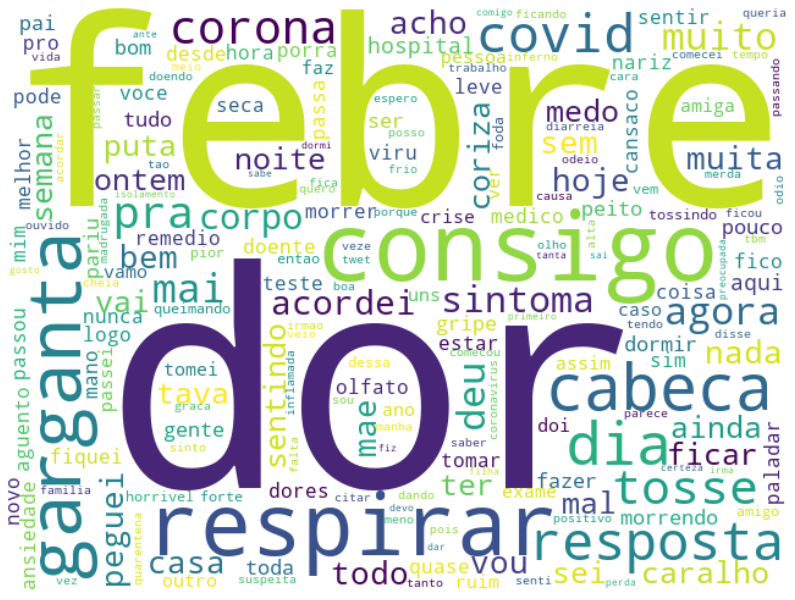

In [24]:
wordcloud = WordCloud(
    width=640, height=480,
    background_color="white", collocations=False,
    stopwords=["nao", "estou", "duvida"]
).generate(" ".join([normalizar.fit(frase) for frase in hashtags_[hashtags_['classify'] == 'positivo']["clean_comment"].tolist()]))

plt.figure(figsize=(14, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

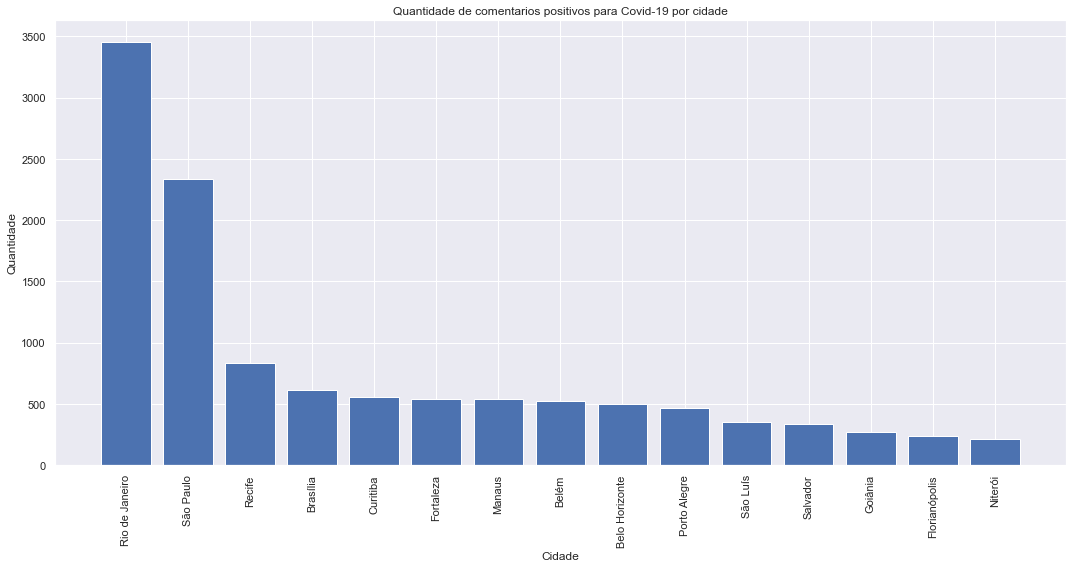

In [10]:
# Pega todos os usuarios do estado de sao paulo
# sp = users_[users_['state'] == 'SP'].copy()
# Sem filtrar por estado...
usr = users_.copy()
usr['count'] = 1
# filtra estes usuarios com comentarios identificados como positivo
nusr = hashtags_[(hashtags_['username'].isin(usr['username'])) & (hashtags_['classify'] == 'positivo')]['username']
# Tendo os usuarios com comentarios positivos filtra novamente
usr = usr[usr['username'].isin(nusr)]
# Agrupa e soma a quantidade por cidade do estado de sao paulo
usr = usr.drop_duplicates("username").groupby(['city']).sum().reset_index()[['city', 'count']].sort_values(by=['count'], ascending=False)

# Grafico
plt.figure(figsize=(15, 8))
plt.title("Quantidade de comentarios positivos para Covid-19 por cidade")
plt.bar(usr['city'][:15], usr['count'][:15])
plt.xticks(rotation=90)
plt.xlabel("Cidade")
plt.ylabel("Quantidade")
plt.tight_layout()
plt.show()

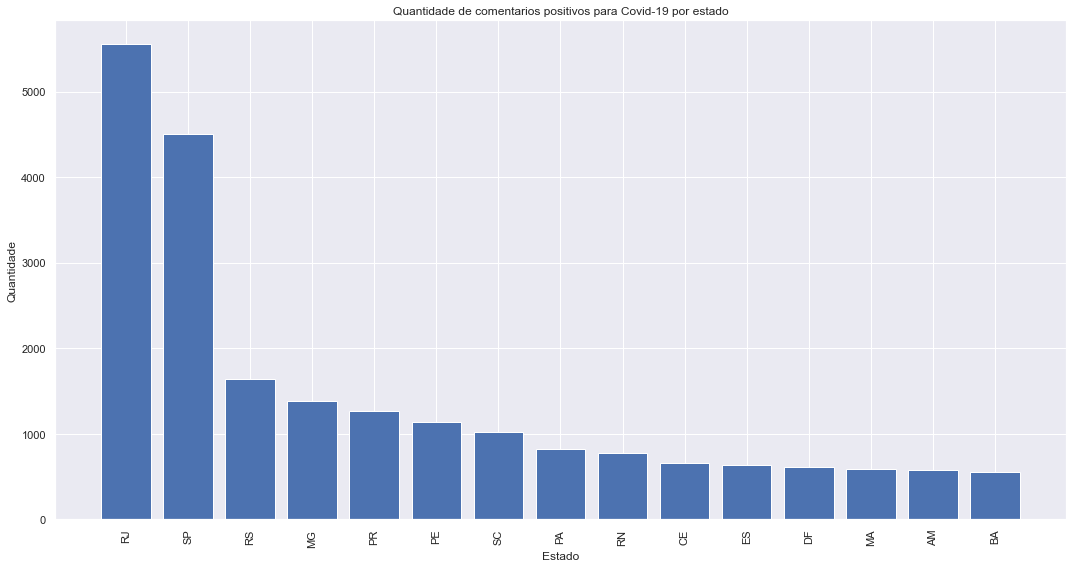

In [11]:
# Pega todos os usuarios do estado de sao paulo
# sp = users_[users_['state'] == 'SP'].copy()
# Sem filtrar por estado...
usr = users_.copy()
usr['count'] = 1
# filtra estes usuarios com comentarios identificados como positivo
nusr = hashtags_[(hashtags_['username'].isin(usr['username'])) & (hashtags_['classify'] == 'positivo')]['username']
# Tendo os usuarios com comentarios positivos filtra novamente
usr = usr[usr['username'].isin(nusr)]
# Agrupa e soma a quantidade por cidade do estado de sao paulo
usr = usr.drop_duplicates("username").groupby(['state']).sum().reset_index()[['state', 'count']].sort_values(by=['count'], ascending=False)

# Grafico
plt.figure(figsize=(15, 8))
plt.title("Quantidade de comentarios positivos para Covid-19 por estado")
plt.bar(usr['state'][:15], usr['count'][:15])
plt.xticks(rotation=90)
plt.xlabel("Estado")
plt.ylabel("Quantidade")
plt.tight_layout()
plt.show()

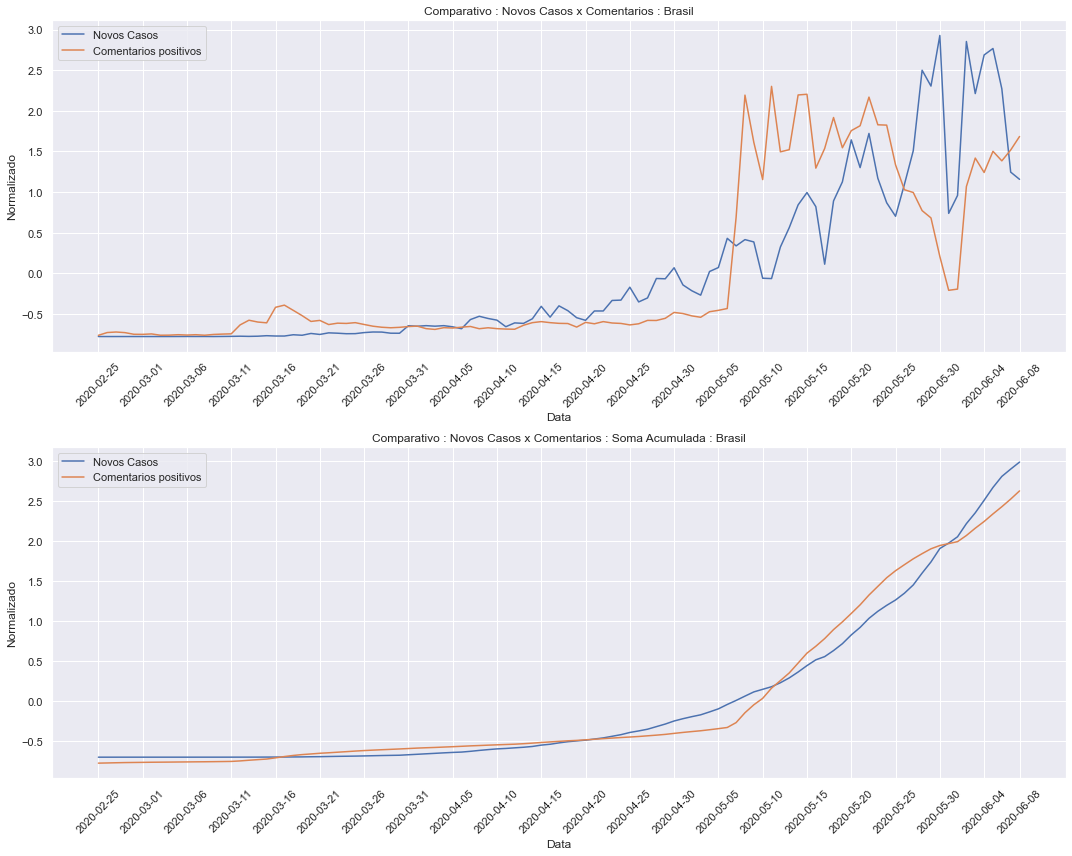

In [16]:
steps = 5

df_dt = hashtags_[hashtags_['classify'] == 'positivo'].drop_duplicates("username").copy()
df_dt['date'] = df_dt['timestamp'].map(lambda x: datetime.strptime(x.strftime('%Y-%m-%d'), '%Y-%m-%d'))
df_dt['count'] = 1
df_dt = df_dt.groupby([df_dt['date'].dt.date]).sum().reset_index()
df_dt = df_dt[df_dt['date'] > pd.Timestamp(2020, 1, 1)]

sp_covid_data = df_covid[["date", "newCases", "newDeaths"]].copy()
sp_covid_data["date"] = pd.to_datetime(sp_covid_data["date"], format='%Y-%m-%d')
sp_covid_data = sp_covid_data.groupby([sp_covid_data["date"].dt.date]).sum().reset_index()

df_merged = []
for idx, row in sp_covid_data.iterrows():
    dt_search = row["date"]
    found = df_dt[df_dt["date"] == dt_search]
    if len(found) > 0:
        df_merged.append(list(row.to_numpy()) + [int(found["count"])])
df_merged = pd.DataFrame(df_merged, columns=["date", "newCases", "newDeaths", "numComments"])

datas = df_merged["date"].to_numpy()
tempo = np.arange(1, len(datas) + 1)
numero_tempo = list(np.arange(1, len(datas), steps))
numero_tempo = numero_tempo + [max(numero_tempo) + (steps - 1)]
data_tempo = list(datas[::steps]) + [datas[-1]]

calc_novos_casos = df_merged["newCases"] / 212_000_000
calc_numero_comments = (df_merged["numComments"] * 0.75) / 8_280_000
novos_casos = scale(calc_novos_casos)
numero_comments = scale(calc_numero_comments)
# novos_casos = df_merged["newCases"]
# numero_comments = (df_merged["numComments"] * 0.75)
cumsum_novos_casos = scale(np.cumsum(calc_novos_casos))
cumsum_numero_comments = scale(np.cumsum(calc_numero_comments))


plt.figure(figsize=(15, 12))
plt.subplot(2, 1, 1)
plt.title("Comparativo : Novos Casos x Comentarios : Brasil")
plt.plot(tempo, novos_casos, label="Novos Casos")
plt.plot(tempo, numero_comments, label="Comentarios positivos")
plt.xticks(numero_tempo, data_tempo, rotation=45)
plt.xlabel("Data")
plt.ylabel("Normalizado")
plt.legend()
plt.subplot(2, 1, 2)
plt.title("Comparativo : Novos Casos x Comentarios : Soma Acumulada : Brasil")
plt.plot(tempo, cumsum_novos_casos, label="Novos Casos")
plt.plot(tempo, cumsum_numero_comments, label="Comentarios positivos")
plt.xticks(numero_tempo, data_tempo, rotation=45)
plt.xlabel("Data")
plt.ylabel("Normalizado")
plt.legend()
plt.tight_layout()
plt.show()

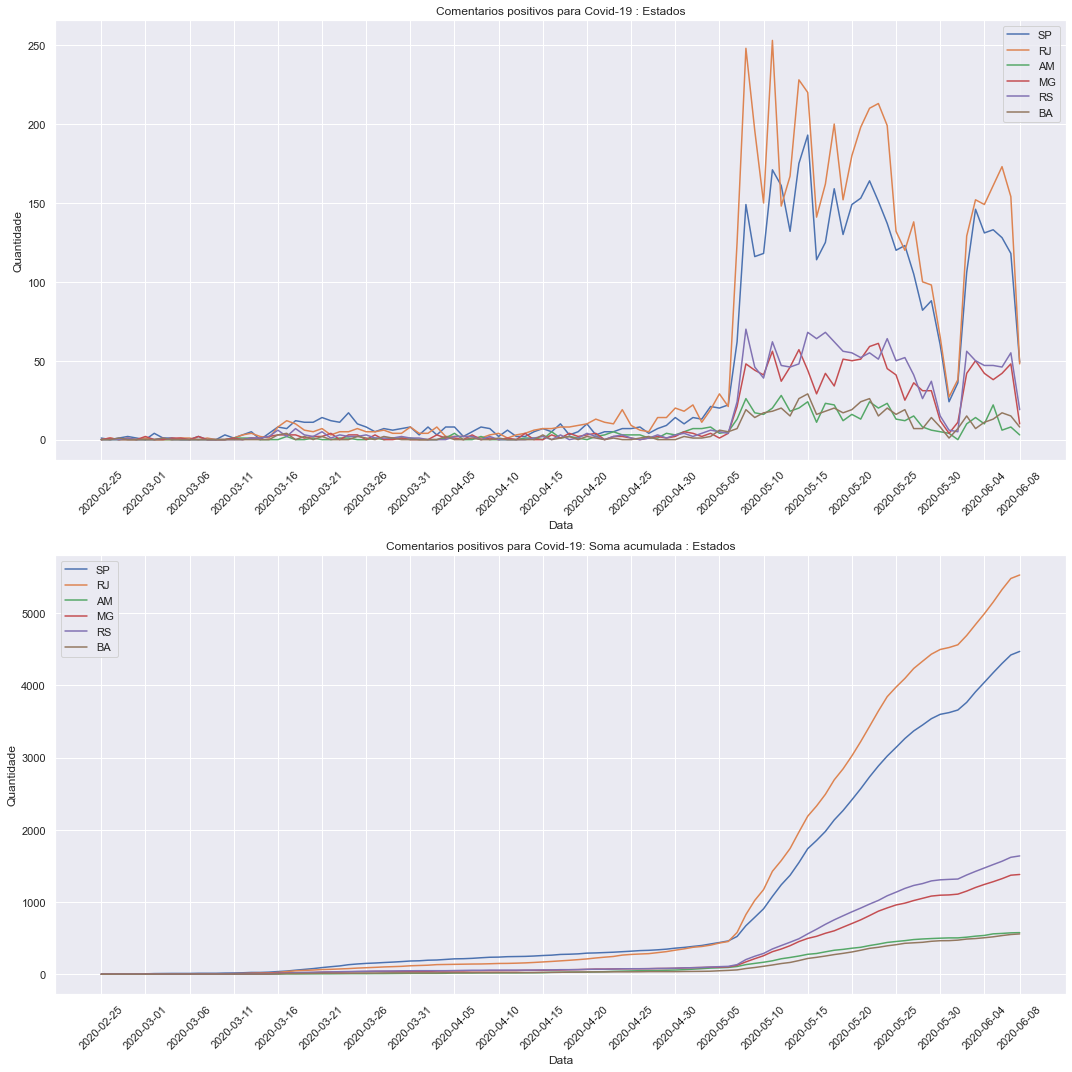

In [17]:
usr = users_.copy()

estados = ["SP", "RJ", "AM", "MG", "RS", "BA"]
list_df = []
for estado in estados:
    usr_ = usr[usr["state"] == estado]
    df_dt_ = hashtags_[
        (hashtags_['username'].isin(usr_['username'])) & (hashtags_['classify'] == 'positivo')
    ].drop_duplicates("username").copy()
    df_dt_['date'] = df_dt_['timestamp'].map(lambda x: datetime.strptime(x.strftime('%Y-%m-%d'), '%Y-%m-%d'))
    df_dt_['count'] = 1
    df_dt_ = df_dt_.groupby([df_dt_['date'].dt.date]).sum().reset_index()
    df_dt_ = df_dt_[df_dt_['date'] > pd.Timestamp(2020, 1, 1)]
    list_df.append(df_dt_)

df_merged = []
for idx, row in sp_covid_data.iterrows():
    dt_search, list_cnt = row["date"], []
    for df_search in list_df:
        val_ = 0
        found_ = df_search[df_search["date"] == dt_search]
        if len(found_) > 0:
            val_ = int(found_["count"])
        list_cnt.append(val_)
    df_merged.append([dt_search] + list_cnt)
df_merged = pd.DataFrame(df_merged, columns=["date"] + estados)


datas = df_merged["date"].to_numpy()
tempo = np.arange(1, len(datas) + 1)
numero_tempo = list(np.arange(1, len(datas), steps))
numero_tempo = numero_tempo + [max(numero_tempo) + (steps - 1)]
data_tempo = list(datas[::steps]) + [datas[-1]]

steps = 5
plt.figure(figsize=(15, 15))
plt.subplot(2, 1, 1)
plt.title("Comentarios positivos para Covid-19 : Estados")
for estado in estados:
    cnt_ = df_merged[estado]
    plt.plot(tempo, cnt_, label=estado)
plt.xticks(numero_tempo, data_tempo, rotation=45)
plt.xlabel("Data")
plt.ylabel("Quantidade")
plt.legend()
plt.subplot(2, 1, 2)
plt.title("Comentarios positivos para Covid-19: Soma acumulada : Estados")
for estado in estados:
    cnt_ = df_merged[estado]
    cumsum_ = np.cumsum(cnt_)
    plt.plot(tempo, cumsum_, label=estado)
plt.xticks(numero_tempo, data_tempo, rotation=45)
plt.xlabel("Data")
plt.ylabel("Quantidade")
plt.legend()
plt.tight_layout()
plt.show()